### Building a Tree Code III: Building the Tree

In this series of notebooks we will build a tree code for determining the acceleration from a set of "particles" (point masses) in $O(N\log N)$ time.

This is the second part, building the tree itself, starting from a list of Morton keys.

In [ ]:
%matplotlib inline

# make notebook as wide as browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from dataclasses import dataclass
import numpy as np

import numpy.random as rng
rng.seed(24238929)

Here is our ParticleSet struct-of-arrays from the previous notebook:

In [ ]:
class ParticleSet(object):
    def __init__(self, N):
        self.N = N
        self.pos  = np.zeros((N,3), dtype=np.float64)
        self.vel  = np.zeros((N,3), dtype=np.float64)
        self.acc  = np.zeros((N,3), dtype=np.float64)
        self.pot  = np.zeros(N,     dtype=np.float64)
        self.mass = np.zeros(N,     dtype=np.float64)
        self.id   = np.zeros(N,     dtype=np.uint32)

    # permute the paticle set according to a permutation array
    # (used for sorting the particles)
    def permute(self, index):
        self.pos[:,:]  = self.pos[index,:]
        self.vel[:,:]  = self.vel[index,:]
        self.acc[:,:]  = self.acc[index,:]
        self.pot[:]  = self.pot[index]
        self.mass[:] = self.mass[index]
        self.id[:]  = self.id[index]

    # find the bounding box for the particles stored in this set
    def boundingCube(self):
        self.boxMin = np.min(self.pos) * np.ones(3) # keep bounding box larger than particles' range
        self.boxMax = np.max(self.pos) * np.ones(3) * (1+3e-10)
        self.center = 0.5*(self.boxMax + self.boxMin)
        self.halfWidth = 0.5*(self.boxMax[0]-self.boxMin[0])

Here is our Morton key class from the previous notebook:

In [ ]:
class Morton():
    """
    Morton key class for sorting particles according to Z-order
    """
    def __init__(self, boxMin, boxMax):
        self.boxMin = boxMin
        self.scale = 1/(boxMax - boxMin)
        # some constants
        self.m1  = 0x3ffffffffff
        self.c64 = 0x3ff0000000000000000ffffffff
        self.c32 = 0x3ff00000000ffff00000000ffff
        self.c16 = 0x30000ff0000ff0000ff0000ff0000ff
        self.c8  = 0x300f00f00f00f00f00f00f00f00f00f
        self.c4  = 0x30c30c30c30c30c30c30c30c30c30c3
        self.c2  = 0x9249249249249249249249249249249

        # x-coordinate in Morton key changes most rapidly
        self.mask = np.array([ [-1,-1,-1],
                               [ 1,-1,-1],
                               [-1, 1,-1],
                               [ 1, 1,-1],
                               [-1,-1, 1],
                               [ 1,-1, 1],
                               [-1, 1, 1],
                               [ 1, 1, 1] ])
    def makeKey(self, pos):
        """
        Make a morton key as a binary number using bit-twiddling tricks
        """
        pscaled = (pos-self.boxMin) * self.scale
        # assume that pos is on [0,1)
        p = (pscaled*((1<<42)))
        key = 0
        for d in range(3):
            r = int(p[d])
            r &= self.m1
            r = (r | (r << 64)) & self.c64
            r = (r | (r << 32)) & self.c32
            r = (r | (r << 16)) & self.c16
            r = (r | (r << 8))  & self.c8
            r = (r | (r << 4))  & self.c4
            r = (r | (r << 2))  & self.c2
            key |= (r<<d)
        return key

    # get the octal value for level from key
    def getOct(self, key, level):
        shr = 123-3*(level)
        return (key>>shr)&7

Make a new set of particles

In [ ]:
N = 100000
p = ParticleSet(N)
p.pos[:,:] = 2*rng.rand(N,3) - 1
p.boundingCube()
print(f"{p.boxMin} : {p.boxMax}")
print(f"{p.center}  {p.halfWidth}")

Armed with the ability to make Morton keys, we can create the keys and then use them to sort the particles into Morton order:

In [ ]:
morton = Morton(p.boxMin, p.boxMax)

keys = np.ones( p.N, dtype=object)
for i in range(p.N):
    keys[i] = morton.makeKey(p.pos[i])

In [ ]:
# sort the keys, finding the permutation
index = np.argsort(keys)
# get the inverse permutation to put them back
rindex = np.empty(N, dtype=np.uint32)
rindex[index] = np.arange(N, dtype=np.uint32)

# permute the particles and their keys into Morton order
p.permute(index)
keys[:] = keys[index]

# check that the keys are sorted and that the positions are in ascending Morton order
for i in range(p.N-1):
    assert keys[i+1]>keys[i]
    assert morton.makeKey(p.pos[i+1]) > morton.makeKey(p.pos[i]) 
print("OK")

<hr style="background-color: rgb(0,0,0);height: 2.0px;"/>

Now that we have a way to calculate Morton keys, we can turn to building the octree to contain our particle set. We will represent the
tree as an array of nodes. Once again, we have a choice: array-of-structs or struct-of-arrays? We will choose struct-of-arrays this
time as the only way we loop over tree nodes is through recursive tree-walk functions which wouldn't benefit from numpy's speed at doing array operations.

First we create numpy type to hold a tree node. Here again we use the @dataclass decorator:

In [ ]:
@dataclass
class TreeNode:
    center: np.ndarray
    halfWidth: float
    begin: int
    end:int
    parent: int
    firstChild: int
    childCount: int
    whichChild: int
    level: int

Next, we create a function to build the tree. 

The simplest implementation of a tree node keeps a pointer to each child, up to eight pointers. To save space,
we will store a pointer (just the index) to the first child only and store the number of children. This means that all children of a given node
must be stored contiguously. The tree array will look like:

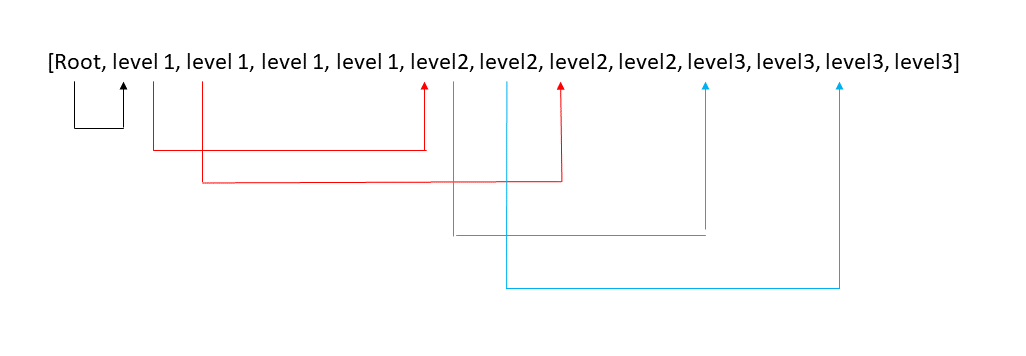

To figure out where everything will be stored, we traverse the points twice. The first time simply counts the number of nodes at each level;
the next time actually builds the tree. 

We need to specify how far down to create children. We do this by specifying the maximum size of a leaf node; once we have fewer than ```maxLeafSize``` particles in a node, we don't bother further subdividing it. Note that this is the maximum size; most leaves will have fewer points.

Here is the counting traversal:

In [ ]:
def inOrderTraversal1(parentLevel, begin, end):
    """
    Traverse Morton keys in a depth-first search to count number of nodes at each level
    """
    global nNodes, nLeaves, avgLeafSize # won't need these to be global once we build a class
    count = 0

    # get the octant of first child from direction of first point in that child
    direction = morton.getOct(keys[begin], parentLevel)

    # count the number of points within each child by traversing the particle set's keys
    while (begin<=end):
        
        # count number of points in this octant (direction), i.e. with the same oct at this level
        count = 0;
        while begin <= end:
            if morton.getOct(keys[begin], parentLevel) == direction:
                begin += 1
                count += 1
            else:
                break  # got total number of particles in this octant

        # add one to the count of nodes at this level (+1 from my parent)
        levelCount[parentLevel+1] += 1
        nNodes += 1

        # if the cell isn't big enough to have children, it is a leaf cell
        if count <= maxLeafSize:
            nLeaves += 1
            avgLeafSize += count
        else:
            # otherwise, keep traversing depth-first, to fill in the octants below this one
            inOrderTraversal1(parentLevel+1, begin-count, begin-1)

        # get the next direction (the next octant) and continue
        if begin <= end:
            direction = morton.getOct(keys[begin], parentLevel)

In [ ]:
maxLeafSize = 32

levelCount = np.zeros(32, dtype=np.int32)
levelCount[0] = 1 # root node
nNodes = 1
nLeaves = 0
avgLeafSize = 0

inOrderTraversal1(0, 0, N-1)
avgLeafSize /= nLeaves
print(f"number of nodes at each level: {levelCount}")
print(f"total number of nodes: {nNodes} must equal sum of levelCount: {levelCount.sum()}")
print(f"number of leaves: {nLeaves}  average leaf size: {avgLeafSize: 0.3f}")

With this, we are ready to build the tree by filling in the tree node data. Here is the traversal. It's structure is the
same, but this time, having the number of nodes at each level, we can compute all of the firstChild and childCount information.

In [ ]:
def inOrderTraversal2(parentLevel, begin, end, parent, center, halfWidth):
    """
    """
    global nodePointer
    
    # some sanity checks
    assert parentLevel < 32
    assert begin < end
    assert tree[parent].firstChild == 0 # shouldn't be here if parent had any children
    assert tree[parent].childCount == 0 # these should already have been filled in

    # get direction to first octant from first particle
    direction = morton.getOct(keys[begin], parentLevel)

    # loop over all particles in parent cell (in order due to Morton ordering)
    while begin <= end:
        assert direction <= 7

        # count number of points in this octant (direction)
        count = 0;
        while begin <= end:
            if morton.getOct(keys[begin], parentLevel) == direction:
                begin += 1
                count += 1
            else:
                break # got total number of particles in this octant

        assert count > 0

        # get child node number in tree & move pointer over one
        child = levelPointer[parentLevel+1]
        levelPointer[parentLevel+1] += 1

        if tree[parent].firstChild == 0:
            # first child of parent
            tree[parent].firstChild = child
            tree[parent].childCount = 1
        else:
            # subsequent children of parent
            tree[parent].childCount += 1
            assert tree[parent].childCount <= 8

        # fill in tree node for child
        tree[child].level = parentLevel+1
        tree[child].parent = parent
        tree[child].begin = begin - count
        tree[child].end = begin - 1
        tree[child].halfWidth = halfWidth
        tree[child].center = center + halfWidth*morton.mask[direction]
        tree[child].whichChild = direction
        tree[child].firstChild = 0
        tree[child].childCount = 0

        nodePointer += 1
        assert nodePointer <= nNodes

        # if child count was large enough, recurse to next level
        if count > maxLeafSize:
            inOrderTraversal2(tree[child].level, begin-count, begin-1, child, \
                                   tree[child].center, 0.5*tree[child].halfWidth)

        #  get the next direction (the next octant) and continue
        if begin <= end:
            direction = morton.getOct(keys[begin], parentLevel)


Now we create the empty tree to be filled in and set the root node information.

```levelPointer[level]``` contains the index into ```tree``` at which nodes on each level begin. It gets incremented every time
a new node is created.

In [ ]:
# create an array of empty nodes to hold the tree
tree = [ TreeNode(0,0,0,0,0,0,0,0,0) for i in range(nNodes) ] 

# fill the root node information
tree[0].center = p.center        # this is just the bounding box of our ParticleSet
tree[0].halfWidth = p.halfWidth
tree[0].begin = 0                # and contains all of the particles
tree[0].end = N-1
tree[0].parent = np.Inf # some random bad value
tree[0].firstChild = 0
tree[0].childCount = 0
tree[0].level = 0

levelPointer = np.zeros(32, dtype='int')
for i in range(1,32):
    levelPointer[i] = levelPointer[i-1] + levelCount[i-1]

for i in range(32):
    print("level {:5d} starts at {:5d} has {:5d} nodes".format(i, levelPointer[i], levelCount[i]))
    if levelCount[i]==0: break
        
nodePointer = 1

Now we can build the tree:

In [ ]:
inOrderTraversal2(tree[0].level, 0, N-1, 0, tree[0].center, 0.5*tree[0].halfWidth)

Having supposedly built the tree, let's check that we have done it correctly!

We traverse the tree, and in each node we check:

1. That there is at least one point in the node
2. That non-leaf nodes have > maxLeafSize points
3. That leaf nodes have <= maxLeafSize points
4. That all the points in each node have positions that belong in that node

In [ ]:
def checkTree(node, retval):
    global checkCount

    if not retval: return False
    
    lo = tree[node].center - tree[node].halfWidth
    hi = tree[node].center + tree[node].halfWidth
    
    # need to watch out for floating-point comparisons
    eps = 1e-13*tree[node].halfWidth
    
    b = tree[node].begin
    e = tree[node].end
    
    npts = e-b+1
    
    if npts <= 0:
        print(f"node {node} has no particles: {npts}")
    
    if tree[node].childCount>0 and npts<=maxLeafSize:
        print(f"node {node} is not a leaf but has {npts} <= maxLeafSize")
        
    if tree[node].childCount==0 and npts>maxLeafSize:
        print(f"node {node} is a leaf but has {npts} > maxLeafSize")
    
    retval = True
    for d in range(3):
        if not ( np.all(p.pos[b:e+1,d]>=lo[d]-eps) and np.all(p.pos[b:e+1,d]<=hi[d]+eps) ):
            print(f"node {node} contains an illegal value:")
            print(f"lo: {lo}   hi: {hi}")
            for i in range(b, e+1):
                if not (p.pos[i,d]>=lo[d] and p.pos[i,d]<=hi[d]):
                    print(f"[{i},{d}]: {lo[d]} <= {p.pos[i,d]} < {hi[d]}")
            return False
                    
    checkCount += 1
    for daughter in range(tree[node].firstChild, tree[node].firstChild + tree[node].childCount):
        checkTree(daughter, retval)
        
    return True

In [ ]:
checkCount = 0
checkTree(0, True)


Now that this seems to work, let's make it into an octree class along with some helpful extra functions:

In [ ]:
@dataclass
class TreeNode:
    center: np.ndarray
    halfWidth: float
    begin: int
    end:int
    level: int
    parent: int
    firstChild: int
    childCount: int
    whichChild: int
        
    def __str__(self):
        return \
            f"    center: {self.center}\n" + \
            f" halfWidth: {self.halfWidth}\n" + \
            f"begin, end: [{self.begin},{self.end}]\n" + \
            f"     level: {self.level}\n" + \
            f"    parent: {self.parent}\n" + \
            f"whichChild: {self.whichChild}\n" + \
            f"firstChild: {self.firstChild}\n" + \
            f"childCount: {self.childCount}\n"
   
class Octree:
    def __init__(self, p, maxLeafSize, check):
        self.p = p
        self.maxLeafSize = maxLeafSize
        self.Morton = Morton(p.boxMin, p.boxMax)
        self.N = N
        
        # make Morton keys
        self.keys = np.empty( self.N, dtype='object')
        for i in range(self.N):
            self.keys[i] = self.Morton.makeKey(p.pos[i])
        
        # find permutation which sorts the keys
        self.index = np.argsort(self.keys)
        # get the inverse permutation
        self.rindex = np.empty(self.N, dtype=np.uint32)
        self.rindex[self.index] = np.arange(self.N, dtype=np.uint32)
        
        # permute the particles and the keys
        p.permute(self.index)
        self.keys[:] = self.keys[self.index]
        
        # perpare for first traversal
        self.nLeaves = 0
        self.nNodes = 1
        self.avgLeafSize = 1
        self.ROOT = 0
        ROOTlevel = 0
        
        self.levelCount = np.zeros(32, dtype=np.uint32)
        self.levelCount[ROOTlevel] = 1
    
        self.inOrderTraversal1(ROOTlevel, 0, self.N-1)
        
        print(f"nNodes: {self.nNodes}")
        
        for i, v in enumerate(self.levelCount):
            if v == 0:
                print(f"maximum depth of tree: {i}")
                break
        
        assert self.nNodes == self.levelCount.sum()
        
        self.avgLeafSize /= self.nLeaves
        print(f"avgLeafSize: {self.avgLeafSize}")
        print(f"nNodes: {self.nNodes}   nLeaves: {self.nLeaves}")

        # prepare for second traversal

        # create a tree array of empty nodes
        self.tree = [ TreeNode(0,0,0,0,0,0,0,0,0) for i in range(self.nNodes)] 

        # fill the root node information
        self.tree[self.ROOT].center = p.center
        self.tree[self.ROOT].halfWidth = p.halfWidth
        self.tree[self.ROOT].begin = 0
        self.tree[self.ROOT].end = self.N-1
        self.tree[self.ROOT].parent = np.Inf
        self.tree[self.ROOT].firstChild = 0
        self.tree[self.ROOT].childCount = 0
        self.tree[self.ROOT].level = 0

        # fill in pointers to where first node at each level lies in tree array
        self.levelPointer = np.zeros(32, dtype='int')
        for i in range(1,32):
            self.levelPointer[i] = self.levelPointer[i-1] + self.levelCount[i-1]

        # pointer to location of current node
        self.nodePointer = 1
        
        self.inOrderTraversal2(self.tree[0].level, 0, self.N-1, 0, self.tree[0].center, 0.5*self.tree[0].halfWidth)
        assert self.nodePointer == self.nNodes
        
        if check:
            self.checkCount = 0
            if not self.checkTree(self.ROOT, True):
                raise ValueError("tree does not check out")
            elif self.checkCount != self.nNodes:
                raise ValueError("tree does not check out")
            else:
                print(f"octree checks out")
            
    def inOrderTraversal1(self, parentLevel, begin, end):
        """
        Traverse Morton keys in a depth-first search to count number of nodes at each level
        """
        count = 0

        # get direction of first child from direction of first point in that child
        direction = self.Morton.getOct(self.keys[begin], parentLevel)

        # count the number of points within each child
        while direction <= 7 and (begin<=end):
            count = 0;
            while begin <= end:
                if self.Morton.getOct(self.keys[begin], parentLevel) == direction:
                    begin += 1
                    count += 1
                else:
                    break

            self.levelCount[parentLevel+1] += 1
            self.nNodes += 1

            # if the cell isn't big enough to have children, it is a leaf cell
            if count <= self.maxLeafSize:
                self.nLeaves += 1
                self.avgLeafSize += count
            else:
                # otherwise, keep travwersing
                self.inOrderTraversal1(parentLevel+1, begin-count, begin-1)

            # get the next direction
            if begin <= end:
                direction = self.Morton.getOct(self.keys[begin], parentLevel)
                
    def inOrderTraversal2(self, parentLevel, begin, end, parent, center, halfWidth):
        """
        Fill all elements of the tree list
        """

        assert parentLevel < 32
        assert begin < end
        assert self.tree[parent].firstChild == 0 # shouldn't be here if parent had any children
        assert self.tree[parent].childCount == 0

        direction = self.Morton.getOct(self.keys[begin], parentLevel)

        while begin <= end:
            assert direction <= 7

            # count number of points in this octant (direction)
            count = 0;
            while begin <= end:
                if self.Morton.getOct(self.keys[begin], parentLevel) == direction:
                    begin += 1
                    count += 1
                else:
                    break
            assert count > 0

            # get child node number in tree
            child = self.levelPointer[parentLevel+1]
            # advance counter to next child node location
            self.levelPointer[parentLevel+1] += 1

            if self.tree[parent].firstChild == 0:
                # first child of parent
                assert self.tree[parent].childCount == 0;
                self.tree[parent].firstChild = child
                self.tree[parent].childCount = 1
            else:
                # subsequent children of parent
                self.tree[parent].childCount += 1
                assert self.tree[parent].childCount <= 8

            self.tree[child].level = parentLevel+1
            self.tree[child].parent = parent
            self.tree[child].begin = begin - count
            self.tree[child].end = begin - 1
            self.tree[child].halfWidth = halfWidth
            self.tree[child].center = center + halfWidth*morton.mask[direction]
            self.tree[child].whichChild = direction
            self.tree[child].firstChild = 0
            self.tree[child].childCount = 0

            self.nodePointer += 1
            assert self.nodePointer <= self.nNodes

            if count > self.maxLeafSize:
                self.inOrderTraversal2(self.tree[child].level, begin-count, begin-1, child, \
                                       self.tree[child].center, 0.5*self.tree[child].halfWidth)


            if begin <= end:
                direction = self.Morton.getOct(self.keys[begin], parentLevel)

    def checkTree(self, node, retval):

        if not retval: return False

        lo = self.tree[node].center - self.tree[node].halfWidth
        hi = self.tree[node].center + self.tree[node].halfWidth

        # need to watch out for floating-point comparisons
        eps = 1e-13*self.tree[node].halfWidth

        b = self.tree[node].begin
        e = self.tree[node].end

        npts = e-b+1

        if npts <= 0:
            print(f"node {node} has no particles: {npts}")

        if self.tree[node].childCount>0 and npts<=self.maxLeafSize:
            print(f"node {node} is a leaf with {npts} > maxLeafSize")

        retval = True
        for d in range(3):
            if not ( np.all(self.p.pos[b:e+1,d]>=lo[d]-eps) and np.all(self.p.pos[b:e+1,d]<=hi[d]+eps) ):
                print(f"node {node} contains an illegal value:")
                print(f"lo: {lo}   hi: {hi}")
                for i in range(b, e+1):
                    if not (self.p.pos[i,d]>=lo[d] and self.p.pos[i,d]<=hi[d]):
                        print(f"[{i},{d}]: {lo[d]} <= {self.p.pos[i,d]} < {hi[d]}")
                        retval = False

        self.checkCount += 1
        for daughter in range(*self.allChildren(node)):
            self.checkTree(daughter, retval)

        return True
    
    def isLeaf(self, node):
        return (self.tree[node].childCount == 0)

    def nodeFirst(self, node):
        return self.tree[node].begin

    def nodeLast(self, node):
        return self.tree[node].end

    def nodeSize(self, node):
        return self.tree[node].end - self.tree[node].begin + 1

    def allPoints(self, node):
        """
        Return the range of particle indices in node, suitable for the range function
        (i.e. the end is one past the last particle)
        """
        return self.tree[node].begin, self.tree[node].end + 1

    def allChildren(self, node):
        """
        Return the range of child node indices, suitable for the range function
        (i.e. the end is one past the last node)
        """
        return self.tree[node].firstChild, self.tree[node].firstChild + self.tree[node].childCount


Try it out:

In [ ]:
# make new particle set
N = 100000
p = ParticleSet(N)
p.pos[:,:] = rng.rand(N,3)
p.boundingCube()
print(f"{p.boxMin} : {p.boxMax}")
print(f"{p.center}  {p.halfWidth}")

In [ ]:
# make tree
octree = Octree(p, 16, True)

In the next notebook, we will finally get around to finding groups of particles and implementing the Barnes-Hut algoithm itself.